# **Pneumonia Detection**
**A machine learning project for detecting pneumonia from chest X-ray images using transfer learning and model tuning techniques.**

## **Pretrained Model Tuning**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix,
  ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### **Dataset Preparation**
We'll create a custom dataset class to handle our X-ray images and apply appropriate transformations for transfer learning.

In [ ]:
# Import data loading function
from _data import load_pneumonia_1d


class PneumoniaDataset(Dataset):
  def __init__(self, features, labels, transform=None):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = self.features[idx]
    label = self.labels[idx]

    # Convert to tensor if not already
    if not torch.is_tensor(image):
      image = torch.tensor(image, dtype=torch.float32)

    # Reshape to (1, 224, 224) if necessary
    if image.shape != (1, 224, 224):
      image = image.reshape(1, 224, 224)

    # Apply transformations if any
    if self.transform:
      image = self.transform(image)

    return image, label

### **Data Loading & Transformation**
Define the transformations needed for pretrained models and load our dataset.

In [ ]:
# Define transformations for transfer learning
train_transforms = transforms.Compose(
  [
    # Convert grayscale to RGB (needed for pretrained models that expect 3 channels)
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Data augmentation
    transforms.RandomHorizontalFlip(),  # Horizontal flips are safe for chest X-rays
    transforms.RandomRotation(5),  # Small rotation angle
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small translations
    # Normalize using ImageNet stats (required for pretrained models)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]
)

test_transforms = transforms.Compose(
  [
    # Convert grayscale to RGB
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Normalize using ImageNet stats
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]
)

# Load data
train_data, test_data = load_pneumonia_1d(
  include_raw=True, include_hog=False, include_lbp=False, pca_mode="none"
)

# Split features and labels
X_train = train_data[:, :-1].reshape(-1, 1, 224, 224)
y_train = train_data[:, -1]
X_test = test_data[:, :-1].reshape(-1, 1, 224, 224)
y_test = test_data[:, -1]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create datasets
train_dataset = PneumoniaDataset(X_train, y_train, transform=train_transforms)
test_dataset = PneumoniaDataset(X_test, y_test, transform=test_transforms)

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### **Training Utilities**
Define helper functions for the training process.

In [ ]:
def make_train_step(model, optimizer, loss_fn):
  """
  Create a single training step function to update model parameters
  """

  def train_step(x, y):
    model.train()
    yhat = model(x)
    loss = loss_fn(yhat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

  return train_step


def evaluate_model(model, dataloader, loss_fn, device):
  """
  Evaluate the model on the given dataloader
  """
  model.eval()
  all_preds = []
  all_targets = []
  cum_loss = 0
  with torch.no_grad():
    for x_batch, y_batch in dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      yhat = model(x_batch)
      val_loss = loss_fn(yhat, y_batch)
      cum_loss += val_loss.item() / len(dataloader)

      # Convert logits to predictions
      probs = torch.sigmoid(yhat)
      preds = torch.round(probs)

      all_preds.append(preds.cpu())
      all_targets.append(y_batch.cpu())

  # Combine all batches
  all_preds = torch.cat(all_preds).numpy()
  all_targets = torch.cat(all_targets).numpy()

  # Compute metrics
  metrics = {
    "loss": cum_loss,
    "accuracy": accuracy_score(all_targets, all_preds),
    "precision": precision_score(all_targets, all_preds),
    "recall": recall_score(all_targets, all_preds),
    "f1": f1_score(all_targets, all_preds),
    "predictions": all_preds,
    "targets": all_targets,
  }

  return metrics


def plot_metrics(train_losses, val_losses, val_metrics, title_prefix="Model"):
  """
  Plot training and validation metrics
  """
  plt.figure(figsize=(15, 10))

  # Plot losses
  plt.subplot(2, 2, 1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title(f"{title_prefix} - Loss over Epochs")
  plt.legend()
  plt.grid(True)

  # Plot accuracy
  plt.subplot(2, 2, 2)
  plt.plot([metrics["accuracy"] for metrics in val_metrics])
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.title(f"{title_prefix} - Validation Accuracy")
  plt.grid(True)

  # Plot F1 score
  plt.subplot(2, 2, 3)
  plt.plot([metrics["f1"] for metrics in val_metrics])
  plt.xlabel("Epoch")
  plt.ylabel("F1 Score")
  plt.title(f"{title_prefix} - Validation F1 Score")
  plt.grid(True)

  # Plot precision and recall
  plt.subplot(2, 2, 4)
  plt.plot([metrics["precision"] for metrics in val_metrics], label="Precision")
  plt.plot([metrics["recall"] for metrics in val_metrics], label="Recall")
  plt.xlabel("Epoch")
  plt.ylabel("Score")
  plt.title(f"{title_prefix} - Validation Precision and Recall")
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()


def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
  """
  Plot confusion matrix
  """
  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  plt.figure(figsize=(8, 8))
  disp.plot(cmap=plt.cm.Blues)
  plt.title(title)
  plt.show()

### **Model Architecture**
Load pretrained models and modify them for our pneumonia classification task.

In [ ]:
def create_resnet_model():
  """
  Create a ResNet18 model with pretrained weights
  """
  # Load pretrained ResNet18
  model = torchvision.models.resnet18(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_densenet_model():
  """
  Create a DenseNet121 model with pretrained weights
  """
  # Load pretrained DenseNet121
  model = torchvision.models.densenet121(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the final layer for binary classification
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 1)  # Binary output

  return model.to(device)


def create_efficientnet_model():
  """
  Create an EfficientNet-B0 model with pretrained weights
  """
  # Load pretrained EfficientNet B0
  model = torchvision.models.efficientnet_b0(weights="IMAGENET1K_V1")

  # Freeze all parameters
  for param in model.parameters():
    param.requires_grad = False

  # Replace the classifier for binary classification
  num_ftrs = model.classifier[1].in_features
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), nn.Linear(num_ftrs, 1)
  )

  return model.to(device)

### **Training Loop**
Define the training process with early stopping and learning rate scheduling.

In [ ]:
def train_model(
  model, trainloader, testloader, model_name="Model", n_epochs=20, patience=3
):
  """
  Train the model with early stopping and learning rate scheduling
  """
  # Calculate class weights for balanced loss
  y_train_np = y_train.cpu().numpy()
  class_weights = compute_class_weight(
    "balanced", classes=np.array([0, 1]), y=y_train_np.flatten()
  )
  pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)
  print(f"Class weights: {class_weights}")
  print(f"Positive class weight: {pos_weight.item()}")

  # Loss function and optimizer
  loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
  optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
  )
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", patience=2, factor=0.5
  )

  # Training step function
  train_step = make_train_step(model, optimizer, loss_fn)

  # Initialize tracking variables
  best_loss = float("inf")
  early_stopping_counter = 0
  best_model_weights = None

  train_losses = []
  val_losses = []
  val_metrics_history = []

  # Training loop
  for epoch in range(n_epochs):
    # Training phase
    epoch_loss = 0
    for i, data in tqdm(
      enumerate(trainloader),
      total=len(trainloader),
      desc=f"Epoch {epoch + 1}/{n_epochs}",
    ):
      x_batch, y_batch = data
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float().to(device)

      loss = train_step(x_batch, y_batch)
      epoch_loss += loss / len(trainloader)

    train_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    val_metrics = evaluate_model(model, testloader, loss_fn, device)
    val_loss = val_metrics["loss"]
    val_losses.append(val_loss)
    val_metrics_history.append(val_metrics)

    print(
      f"Validation Loss: {val_loss:.4f}, Accuracy: {val_metrics['accuracy']:.4f}, "
      f"Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}, "
      f"F1 Score: {val_metrics['f1']:.4f}"
    )

    # Update learning rate
    scheduler.step(val_loss)

    # Check for improvement and early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_weights = model.state_dict().copy()
      early_stopping_counter = 0
      print(f"New best validation loss: {best_loss:.4f}")
    else:
      early_stopping_counter += 1
      print(f"No improvement for {early_stopping_counter} epochs")

    if early_stopping_counter >= patience:
      print("Early stopping triggered")
      break

  # Load best model weights
  if best_model_weights:
    model.load_state_dict(best_model_weights)
    print(f"Loaded best model with validation loss: {best_loss:.4f}")

  # Final evaluation
  final_metrics = evaluate_model(model, testloader, loss_fn, device)
  print("\n=== Final Model Evaluation ===")
  print(f"Loss: {final_metrics['loss']:.4f}")
  print(f"Accuracy: {final_metrics['accuracy']:.4f}")
  print(f"Precision: {final_metrics['precision']:.4f}")
  print(f"Recall: {final_metrics['recall']:.4f}")
  print(f"F1 Score: {final_metrics['f1']:.4f}")

  # Plot metrics
  plot_metrics(train_losses, val_losses, val_metrics_history, title_prefix=model_name)

  # Plot confusion matrix
  plot_confusion_matrix(
    final_metrics["targets"],
    final_metrics["predictions"],
    title=f"{model_name} - Confusion Matrix",
  )

  return model, final_metrics

### **Model Tuning: ResNet18**
Train and evaluate a fine-tuned ResNet18 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [02:28<00:00,  1.10it/s]


Epoch 1/20, Training Loss: 0.1968
Validation Loss: 0.2213, Accuracy: 0.8381, Precision: 0.9164, Recall: 0.8154, F1 Score: 0.8630
New best validation loss: 0.2213


Epoch 2/20: 100%|██████████| 164/164 [02:13<00:00,  1.23it/s]


Epoch 2/20, Training Loss: 0.1314
Validation Loss: 0.2072, Accuracy: 0.8574, Precision: 0.9192, Recall: 0.8462, F1 Score: 0.8812
New best validation loss: 0.2072


Epoch 3/20: 100%|██████████| 164/164 [02:11<00:00,  1.25it/s]


Epoch 3/20, Training Loss: 0.1153
Validation Loss: 0.2019, Accuracy: 0.8702, Precision: 0.9233, Recall: 0.8641, F1 Score: 0.8927
New best validation loss: 0.2019


Epoch 4/20: 100%|██████████| 164/164 [02:10<00:00,  1.25it/s]


Epoch 4/20, Training Loss: 0.1106
Validation Loss: 0.2381, Accuracy: 0.8750, Precision: 0.8824, Recall: 0.9231, F1 Score: 0.9023
No improvement for 1 epochs


Epoch 5/20: 100%|██████████| 164/164 [02:14<00:00,  1.22it/s]


Epoch 5/20, Training Loss: 0.1022
Validation Loss: 0.2102, Accuracy: 0.8798, Precision: 0.9134, Recall: 0.8923, F1 Score: 0.9027
No improvement for 2 epochs


Epoch 6/20: 100%|██████████| 164/164 [02:11<00:00,  1.25it/s]


Epoch 6/20, Training Loss: 0.0972
Validation Loss: 0.2003, Accuracy: 0.8702, Precision: 0.9256, Recall: 0.8615, F1 Score: 0.8924
New best validation loss: 0.2003


Epoch 7/20: 100%|██████████| 164/164 [02:12<00:00,  1.24it/s]


Epoch 7/20, Training Loss: 0.0955
Validation Loss: 0.2125, Accuracy: 0.8814, Precision: 0.9202, Recall: 0.8872, F1 Score: 0.9034
No improvement for 1 epochs


Epoch 8/20: 100%|██████████| 164/164 [02:22<00:00,  1.15it/s]


Epoch 8/20, Training Loss: 0.0927
Validation Loss: 0.2678, Accuracy: 0.8734, Precision: 0.8659, Recall: 0.9436, F1 Score: 0.9031
No improvement for 2 epochs


Epoch 9/20: 100%|██████████| 164/164 [02:34<00:00,  1.06it/s]


Epoch 9/20, Training Loss: 0.0947
Validation Loss: 0.2048, Accuracy: 0.8782, Precision: 0.9220, Recall: 0.8795, F1 Score: 0.9003
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.2003

=== Final Model Evaluation ===
Loss: 0.2048
Accuracy: 0.8782
Precision: 0.9220
Recall: 0.8795
F1 Score: 0.9003


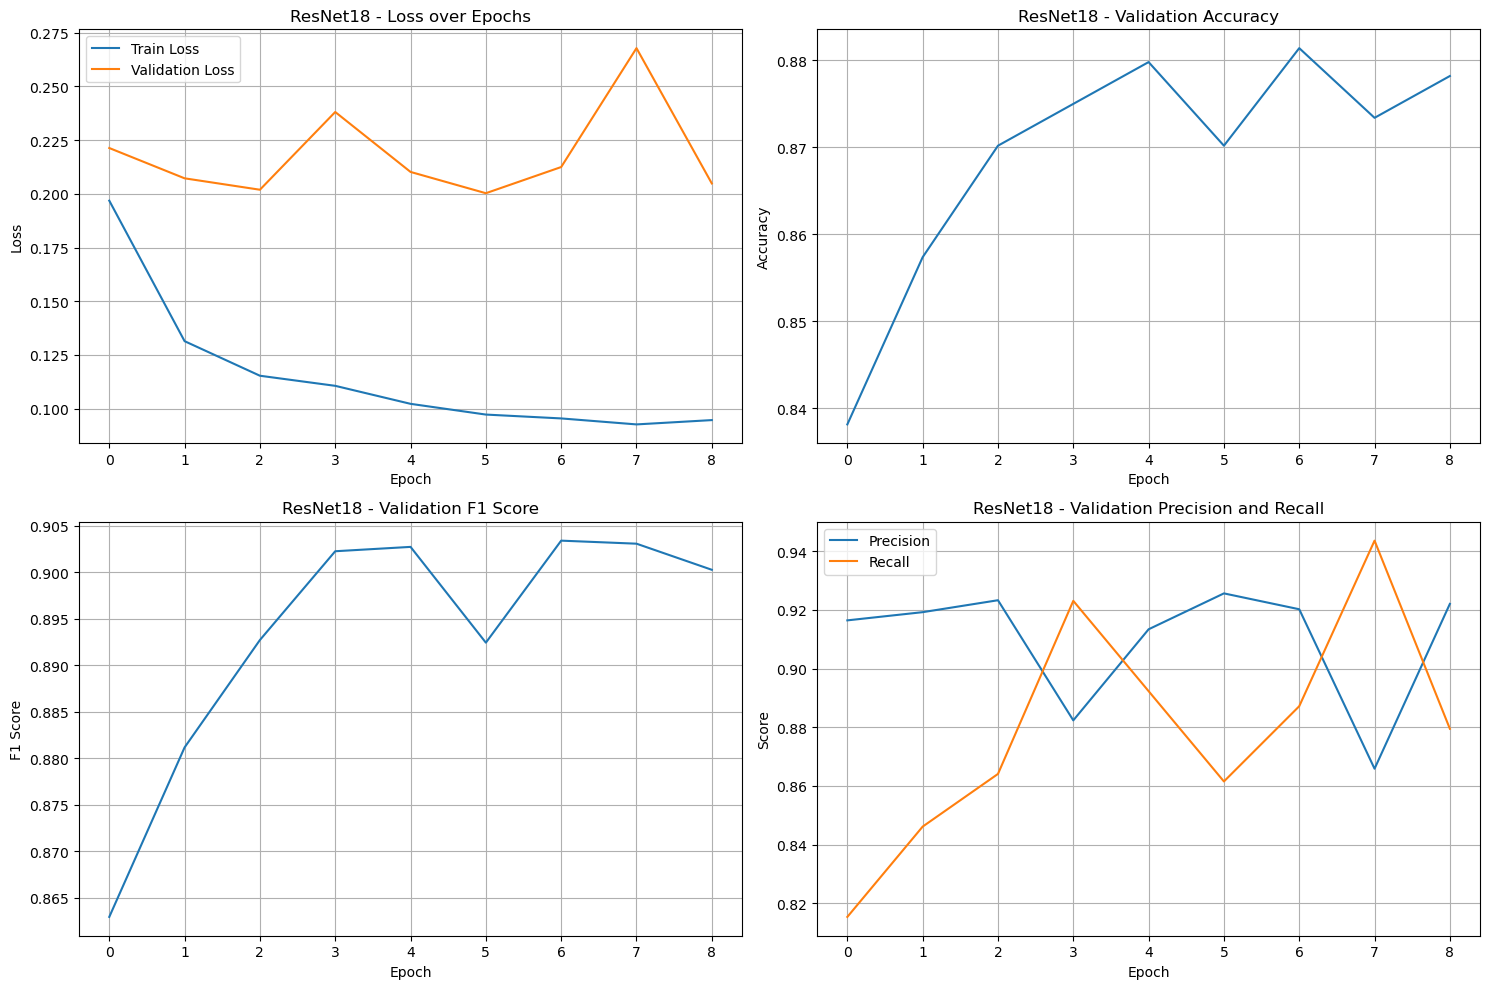

<Figure size 800x800 with 0 Axes>

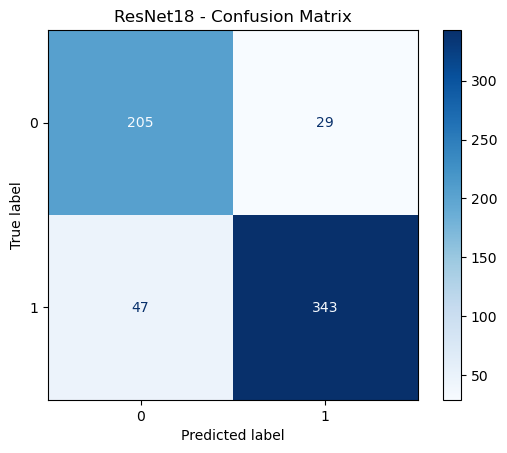

In [ ]:
# Create and train ResNet18 model
resnet_model = create_resnet_model()
resnet_model, resnet_metrics = train_model(
  resnet_model, trainloader, testloader, model_name="ResNet18"
)

### **Model Tuning: DenseNet121**
Train and evaluate a fine-tuned DenseNet121 model.

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/luozihyuan/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 50.5MB/s]


Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [08:01<00:00,  2.93s/it]


Epoch 1/20, Training Loss: 0.2116
Validation Loss: 0.2339, Accuracy: 0.8494, Precision: 0.9088, Recall: 0.8436, F1 Score: 0.8750
New best validation loss: 0.2339


Epoch 2/20: 100%|██████████| 164/164 [07:55<00:00,  2.90s/it]


Epoch 2/20, Training Loss: 0.1347
Validation Loss: 0.2187, Accuracy: 0.8782, Precision: 0.9026, Recall: 0.9026, F1 Score: 0.9026
New best validation loss: 0.2187


Epoch 3/20: 100%|██████████| 164/164 [07:48<00:00,  2.86s/it]


Epoch 3/20, Training Loss: 0.1153
Validation Loss: 0.2479, Accuracy: 0.8718, Precision: 0.8656, Recall: 0.9410, F1 Score: 0.9017
No improvement for 1 epochs


Epoch 4/20: 100%|██████████| 164/164 [07:55<00:00,  2.90s/it]


Epoch 4/20, Training Loss: 0.0994
Validation Loss: 0.2228, Accuracy: 0.8782, Precision: 0.8792, Recall: 0.9333, F1 Score: 0.9055
No improvement for 2 epochs


Epoch 5/20: 100%|██████████| 164/164 [07:48<00:00,  2.86s/it]


Epoch 5/20, Training Loss: 0.0963
Validation Loss: 0.2150, Accuracy: 0.8814, Precision: 0.8873, Recall: 0.9282, F1 Score: 0.9073
New best validation loss: 0.2150


Epoch 6/20: 100%|██████████| 164/164 [08:00<00:00,  2.93s/it]


Epoch 6/20, Training Loss: 0.0914
Validation Loss: 0.2555, Accuracy: 0.8750, Precision: 0.8628, Recall: 0.9513, F1 Score: 0.9049
No improvement for 1 epochs


Epoch 7/20: 100%|██████████| 164/164 [08:02<00:00,  2.94s/it]


Epoch 7/20, Training Loss: 0.0914
Validation Loss: 0.1985, Accuracy: 0.8894, Precision: 0.8983, Recall: 0.9282, F1 Score: 0.9130
New best validation loss: 0.1985


Epoch 8/20: 100%|██████████| 164/164 [07:58<00:00,  2.92s/it]


Epoch 8/20, Training Loss: 0.0849
Validation Loss: 0.2811, Accuracy: 0.8702, Precision: 0.8503, Recall: 0.9615, F1 Score: 0.9025
No improvement for 1 epochs


Epoch 9/20: 100%|██████████| 164/164 [07:50<00:00,  2.87s/it]


Epoch 9/20, Training Loss: 0.0854
Validation Loss: 0.2235, Accuracy: 0.8894, Precision: 0.8886, Recall: 0.9410, F1 Score: 0.9141
No improvement for 2 epochs


Epoch 10/20: 100%|██████████| 164/164 [07:48<00:00,  2.86s/it]


Epoch 10/20, Training Loss: 0.0874
Validation Loss: 0.2106, Accuracy: 0.8894, Precision: 0.8924, Recall: 0.9359, F1 Score: 0.9136
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.1985

=== Final Model Evaluation ===
Loss: 0.2106
Accuracy: 0.8894
Precision: 0.8924
Recall: 0.9359
F1 Score: 0.9136


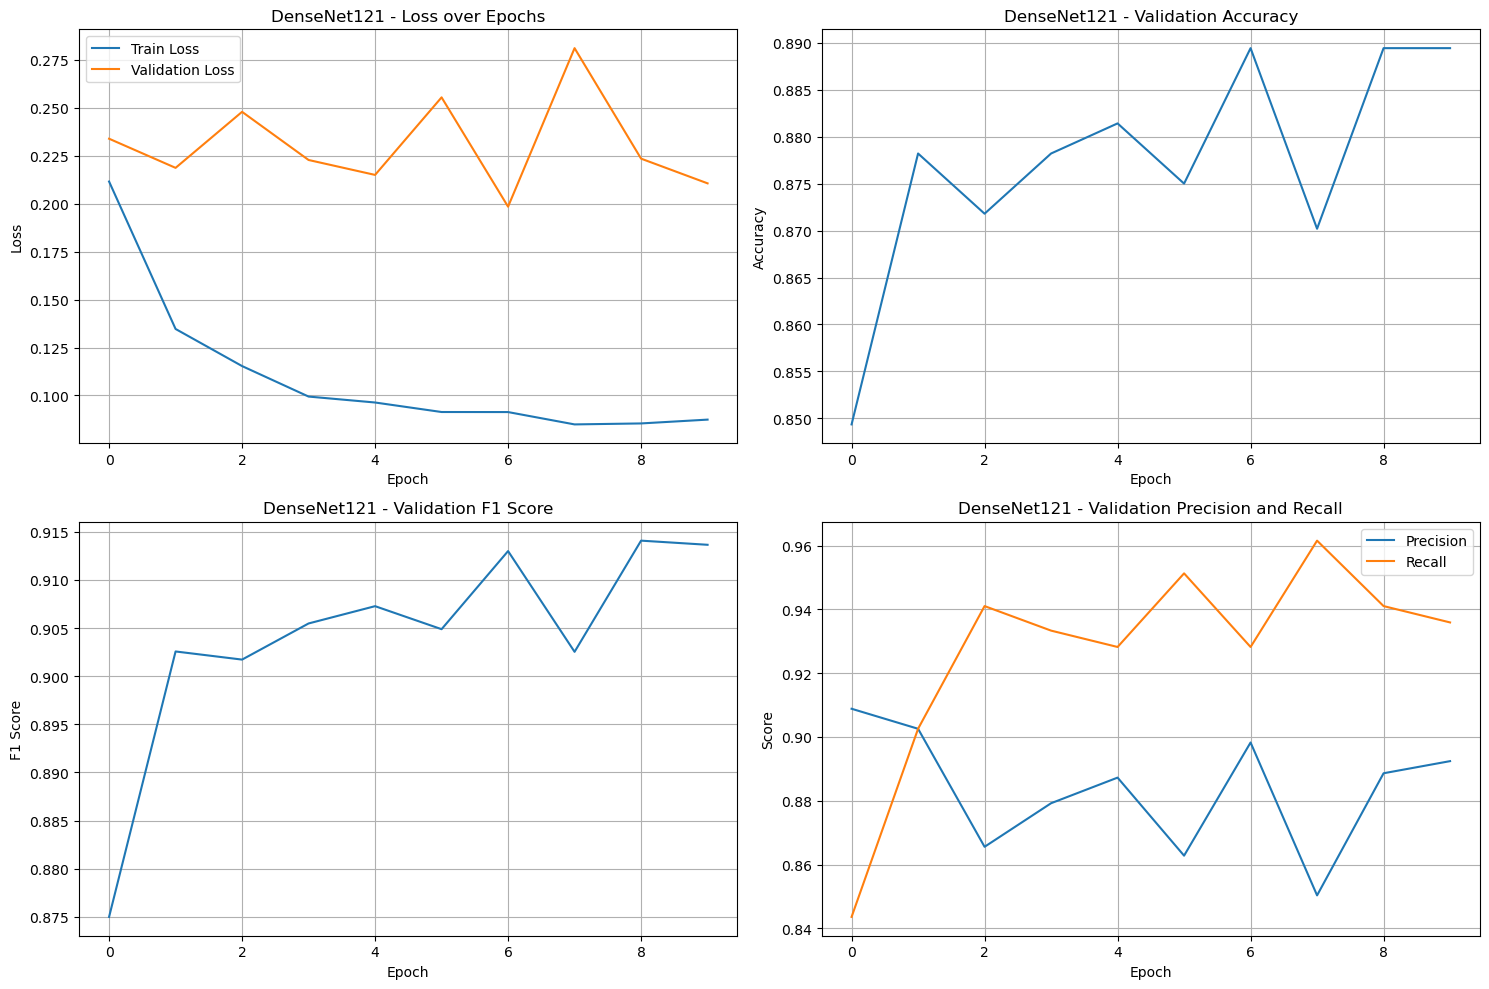

<Figure size 800x800 with 0 Axes>

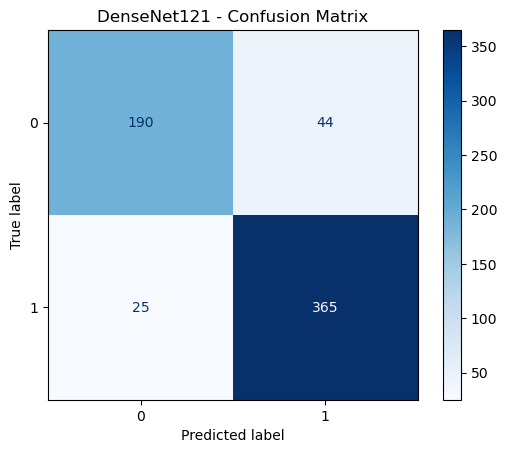

In [ ]:
# Create and train DenseNet121 model
densenet_model = create_densenet_model()
densenet_model, densenet_metrics = train_model(
  densenet_model, trainloader, testloader, model_name="DenseNet121"
)

### **Model Tuning: EfficientNet-B0**
Train and evaluate a fine-tuned EfficientNet-B0 model.

Class weights: [1.93921423 0.6737059 ]
Positive class weight: 0.34741179500386304


Epoch 1/20: 100%|██████████| 164/164 [05:07<00:00,  1.88s/it]


Epoch 1/20, Training Loss: 0.1985
Validation Loss: 0.2328, Accuracy: 0.8413, Precision: 0.9030, Recall: 0.8359, F1 Score: 0.8682
New best validation loss: 0.2328


Epoch 2/20: 100%|██████████| 164/164 [05:10<00:00,  1.90s/it]


Epoch 2/20, Training Loss: 0.1247
Validation Loss: 0.2158, Accuracy: 0.8670, Precision: 0.9050, Recall: 0.8795, F1 Score: 0.8921
New best validation loss: 0.2158


Epoch 3/20: 100%|██████████| 164/164 [05:11<00:00,  1.90s/it]


Epoch 3/20, Training Loss: 0.1099
Validation Loss: 0.2095, Accuracy: 0.8702, Precision: 0.9120, Recall: 0.8769, F1 Score: 0.8941
New best validation loss: 0.2095


Epoch 4/20: 100%|██████████| 164/164 [05:06<00:00,  1.87s/it]


Epoch 4/20, Training Loss: 0.1045
Validation Loss: 0.2099, Accuracy: 0.8766, Precision: 0.9044, Recall: 0.8974, F1 Score: 0.9009
No improvement for 1 epochs


Epoch 5/20: 100%|██████████| 164/164 [05:02<00:00,  1.85s/it]


Epoch 5/20, Training Loss: 0.1007
Validation Loss: 0.1978, Accuracy: 0.8846, Precision: 0.9162, Recall: 0.8974, F1 Score: 0.9067
New best validation loss: 0.1978


Epoch 6/20: 100%|██████████| 164/164 [05:05<00:00,  1.86s/it]


Epoch 6/20, Training Loss: 0.0951
Validation Loss: 0.2206, Accuracy: 0.8830, Precision: 0.8953, Recall: 0.9205, F1 Score: 0.9077
No improvement for 1 epochs


Epoch 7/20: 100%|██████████| 164/164 [05:06<00:00,  1.87s/it]


Epoch 7/20, Training Loss: 0.0931
Validation Loss: 0.2207, Accuracy: 0.8846, Precision: 0.8936, Recall: 0.9256, F1 Score: 0.9093
No improvement for 2 epochs


Epoch 8/20: 100%|██████████| 164/164 [05:06<00:00,  1.87s/it]


Epoch 8/20, Training Loss: 0.0938
Validation Loss: 0.2234, Accuracy: 0.8878, Precision: 0.9000, Recall: 0.9231, F1 Score: 0.9114
No improvement for 3 epochs
Early stopping triggered
Loaded best model with validation loss: 0.1978

=== Final Model Evaluation ===
Loss: 0.2234
Accuracy: 0.8878
Precision: 0.9000
Recall: 0.9231
F1 Score: 0.9114


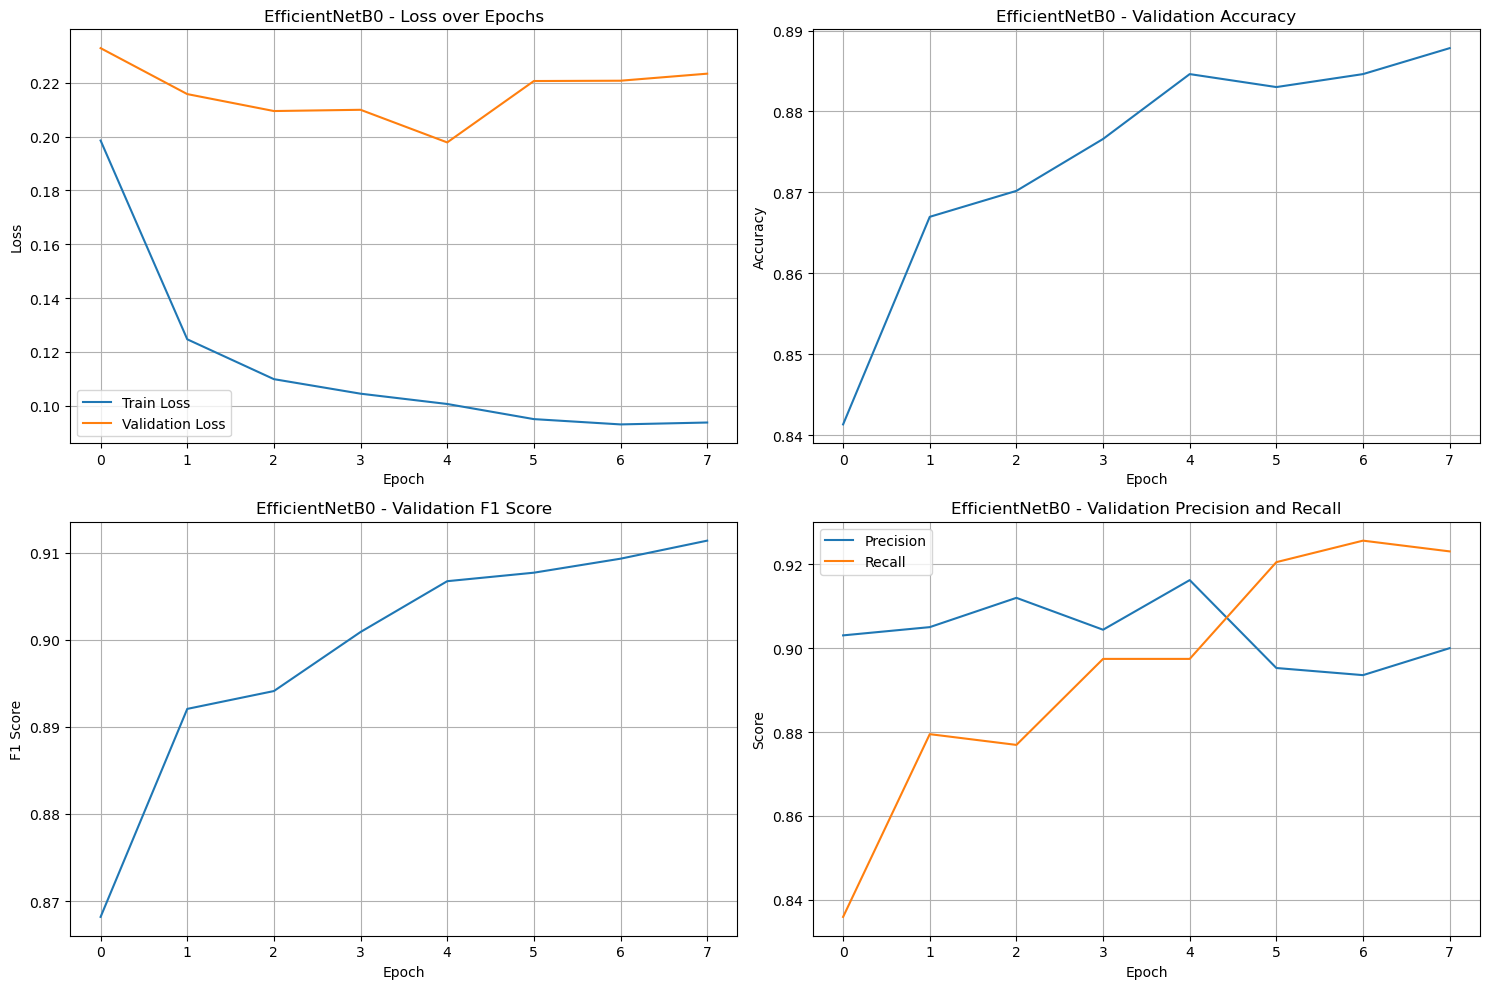

<Figure size 800x800 with 0 Axes>

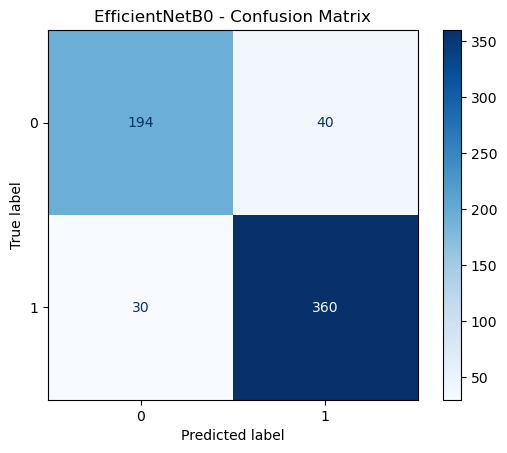

In [ ]:
# Create and train EfficientNet model
efficientnet_model = create_efficientnet_model()
efficientnet_model, efficientnet_metrics = train_model(
  efficientnet_model, trainloader, testloader, model_name="EfficientNetB0"
)

### **Model Comparison**
Compare the performance of all models.

=== Model Comparison ===
                Accuracy  Precision    Recall  F1 Score
Model                                                  
ResNet18        0.878205   0.922043  0.879487  0.900262
DenseNet121     0.889423   0.892421  0.935897  0.913642
EfficientNetB0  0.887821   0.900000  0.923077  0.911392


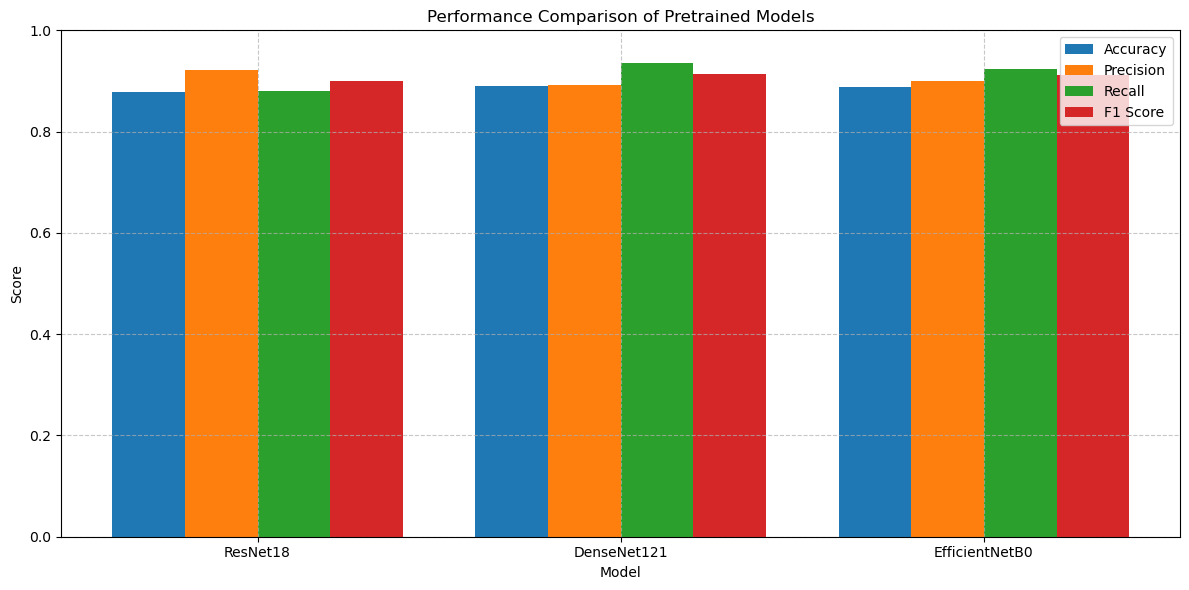

In [ ]:
# Compile results for comparison
model_names = ["ResNet18", "DenseNet121", "EfficientNetB0"]
metrics = [resnet_metrics, densenet_metrics, efficientnet_metrics]

# Create comparison dataframe
comparison_df = pd.DataFrame(
  {
    "Model": model_names,
    "Accuracy": [m["accuracy"] for m in metrics],
    "Precision": [m["precision"] for m in metrics],
    "Recall": [m["recall"] for m in metrics],
    "F1 Score": [m["f1"] for m in metrics],
  }
)

# Display comparison
print("=== Model Comparison ===")
print(comparison_df.set_index("Model"))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(model_names))

# Plot bars for each metric
ax.bar(x - bar_width * 1.5, comparison_df["Accuracy"], bar_width, label="Accuracy")
ax.bar(x - bar_width / 2, comparison_df["Precision"], bar_width, label="Precision")
ax.bar(x + bar_width / 2, comparison_df["Recall"], bar_width, label="Recall")
ax.bar(x + bar_width * 1.5, comparison_df["F1 Score"], bar_width, label="F1 Score")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("Performance Comparison of Pretrained Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(True, linestyle="--", alpha=0.7)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

### **Feature Visualization with Class Activation Maps**
Visualize what the model is focusing on using Grad-CAM.

In [28]:
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from matplotlib import pyplot as plt


class BinaryGradCAM:
  """
  Custom GradCAM implementation for binary classification models with a single sigmoid output
  """

  def __init__(self, model, target_layer):
    self.model = model
    self.target_layer = target_layer
    self.gradients = None
    self.activations = None

    # Register hooks
    self.register_hooks()

    # Ensure model is in eval mode
    self.model.eval()

  def register_hooks(self):
    def forward_hook(module, input, output):
      self.activations = output.detach()

    def backward_hook(module, grad_input, grad_output):
      self.gradients = grad_output[0].detach()

    # Register the hooks
    self.target_layer.register_forward_hook(forward_hook)
    self.target_layer.register_backward_hook(backward_hook)

  def __call__(self, input_tensor, target_class=1):
    """
    Args:
        input_tensor: Input image tensor [1, C, H, W]
        target_class: Target class (0 for negative class, 1 for positive class)

    Returns:
        heatmap: Class activation heatmap
    """
    # Forward pass
    input_tensor.requires_grad_(True)

    # Zero gradients
    self.model.zero_grad()

    # Forward pass to get network output
    output = self.model(input_tensor)

    # For binary classification model with sigmoid output
    if output.shape[-1] == 1 or len(output.shape) == 1:
      # If target_class is 1, we want to maximize the output (positive class)
      # If target_class is 0, we want to minimize the output (negative class)
      if target_class == 1:
        score = output
      else:
        score = 1 - output
    else:
      # For multi-class with softmax output
      score = output[:, target_class]

    # Backward pass
    score.backward()

    # Check if gradients were computed
    if self.gradients is None:
      raise ValueError(
        "No gradients found. Make sure the target layer produces gradients."
      )

    # Get weights from gradients
    weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

    # Create weighted activation map
    activation = self.activations * weights

    # Sum along channel dimension
    cam = torch.sum(activation, dim=1).squeeze().cpu().detach().numpy()

    # ReLU
    cam = np.maximum(cam, 0)

    # Normalize
    if np.max(cam) > 0:
      cam = cam / np.max(cam)

    return cam


def visualize_gradcam(model, target_layer, X_sample, y_sample, model_name):
  """
  Visualize what the model focuses on using custom GradCAM
  """
  # Prepare the input image
  if not torch.is_tensor(X_sample):
    X_sample = torch.tensor(X_sample, dtype=torch.float32)
  if X_sample.shape != (1, 224, 224):
    X_sample = X_sample.reshape(1, 224, 224)

  # Apply test transform to convert to RGB and normalize
  X_trans = test_transforms(X_sample).unsqueeze(0).to(device)

  # Convert the original image to a format suitable for visualization
  img_for_display = X_sample.numpy().squeeze()
  img_for_display = (img_for_display - img_for_display.min()) / (
    img_for_display.max() - img_for_display.min()
  )
  img_for_display = np.uint8(img_for_display * 255)
  img_for_display = cv2.cvtColor(img_for_display, cv2.COLOR_GRAY2RGB)

  # Initialize our custom GradCAM
  grad_cam = BinaryGradCAM(model=model, target_layer=target_layer)

  # Generate heatmap
  grayscale_cam = grad_cam(X_trans, target_class=int(y_sample))

  # Resize heatmap to match input image size
  heatmap = cv2.resize(
    grayscale_cam, (img_for_display.shape[1], img_for_display.shape[0])
  )

  # Overlay heatmap on image
  visualization = show_cam_on_image(img_for_display / 255.0, heatmap, use_rgb=True)

  # Make prediction
  model.eval()
  with torch.no_grad():
    output = model(X_trans)
    pred_prob = torch.sigmoid(output).item()
    pred_class = 1 if pred_prob > 0.5 else 0

  # Display results
  fig, ax = plt.subplots(1, 2, figsize=(12, 5))
  ax[0].imshow(img_for_display)
  ax[0].set_title(
    f"Original Image\nTrue Label: {'Pneumonia' if y_sample == 1 else 'Normal'}"
  )
  ax[0].axis("off")

  ax[1].imshow(visualization)
  ax[1].set_title(
    f"Grad-CAM: {model_name}\nPrediction: {'Pneumonia' if pred_class == 1 else 'Normal'} ({pred_prob:.2f})"
  )
  ax[1].axis("off")

  plt.tight_layout()
  plt.show()

  return visualization


def show_cam_on_image(img, mask, use_rgb=True, colormap=cv2.COLORMAP_JET):
  """
  Apply heatmap to image
  """
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
  if use_rgb:
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

  cam = np.float32(heatmap) / 255 + np.float32(img)
  cam = cam / np.max(cam)
  return np.uint8(255 * cam)

=== Visualization for Normal Case ===


/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


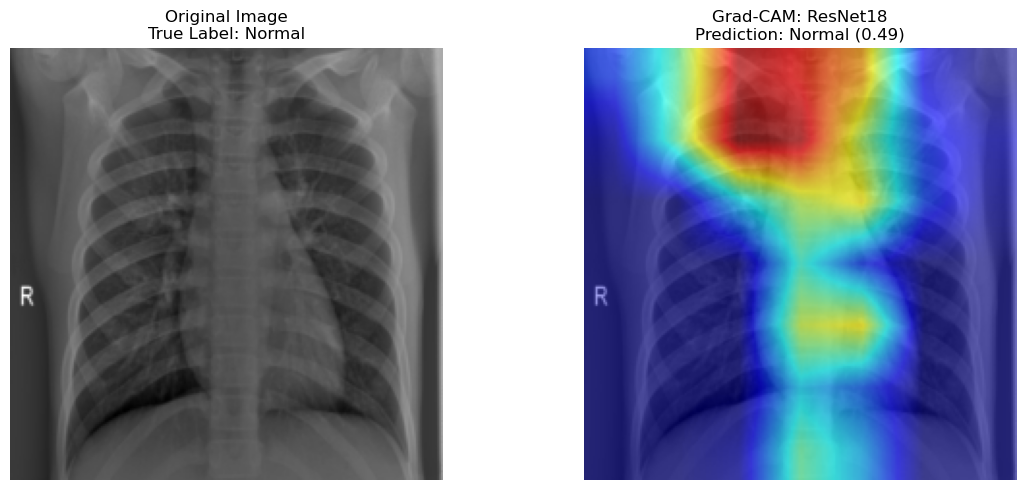

/opt/miniconda3/envs/CS6220/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


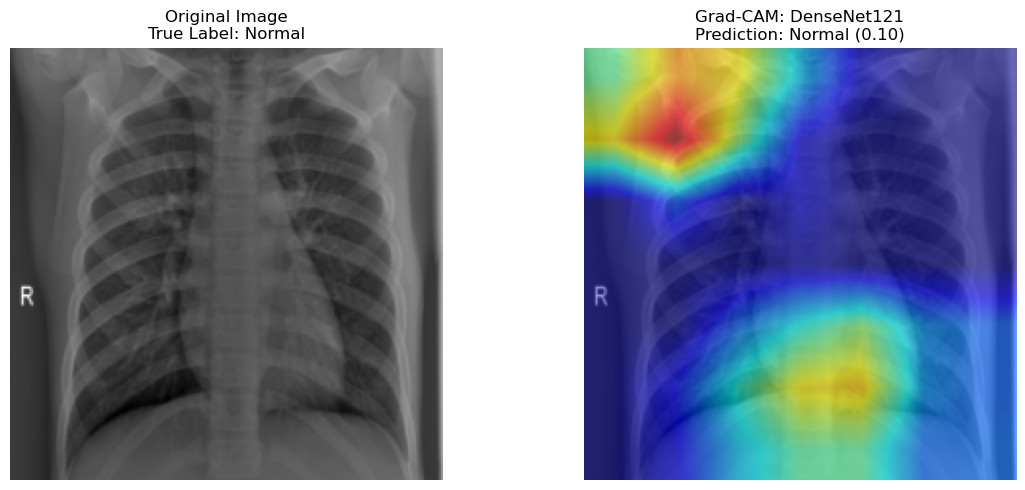

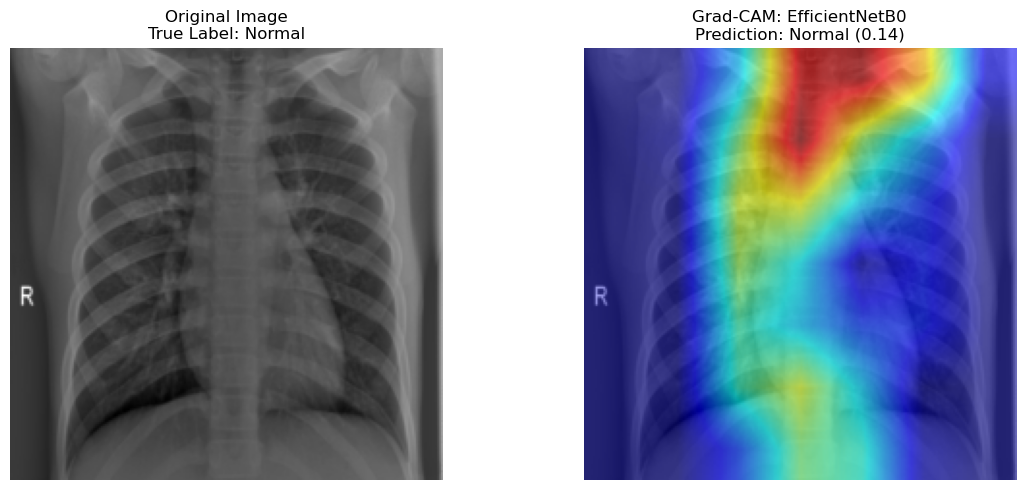


=== Visualization for Pneumonia Case ===


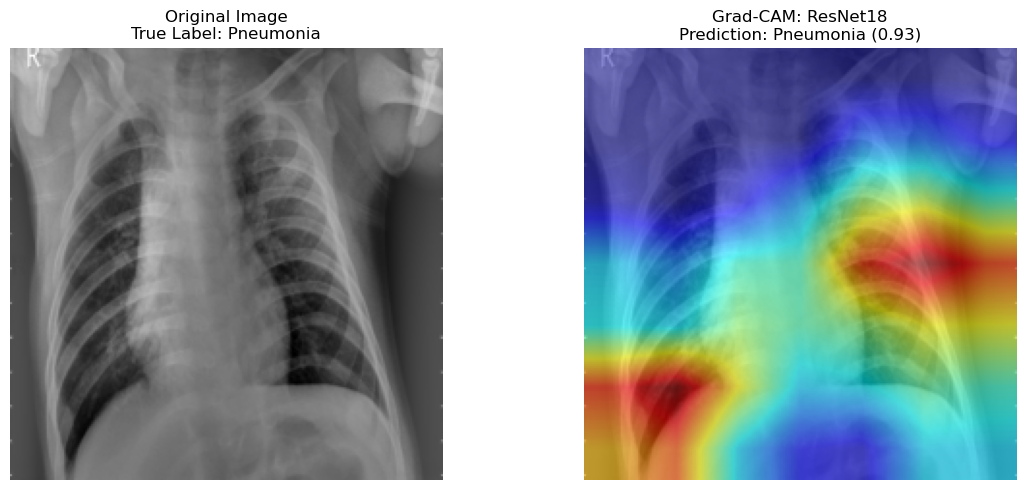

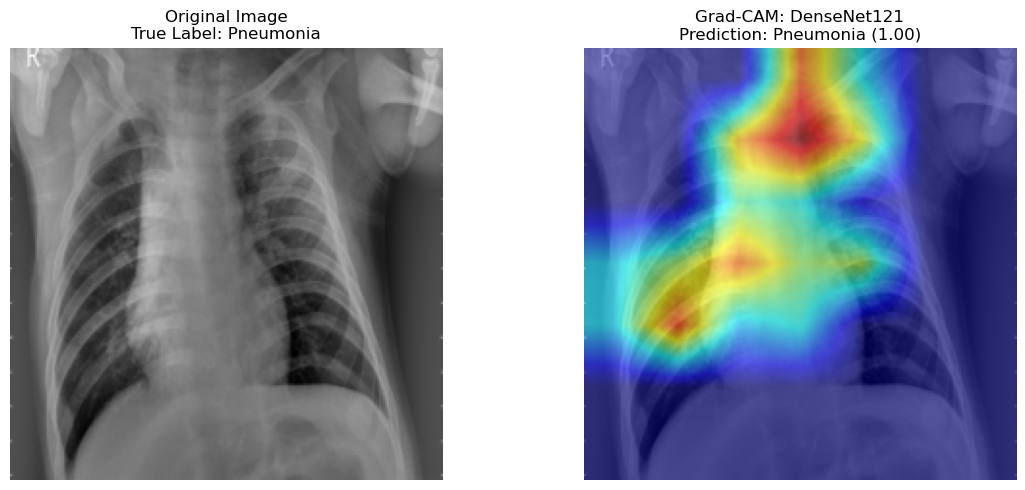

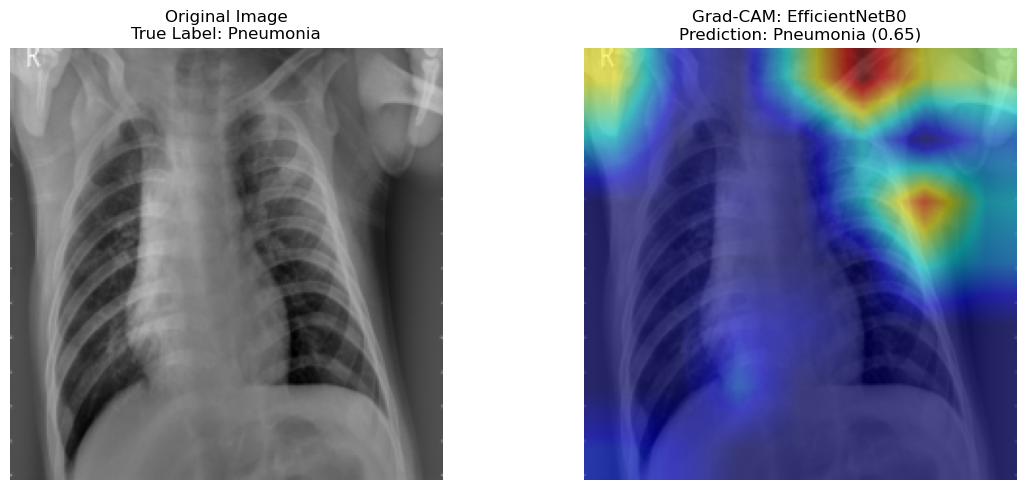

array([[[215, 209,  87],
        [212, 206,  84],
        [207, 201,  79],
        ...,
        [164, 215, 138],
        [156, 206, 130],
        [152, 203, 126]],

       [[215, 209,  87],
        [213, 207,  85],
        [207, 202,  80],
        ...,
        [163, 214, 137],
        [157, 208, 131],
        [153, 204, 127]],

       [[214, 209,  87],
        [213, 208,  86],
        [208, 203,  81],
        ...,
        [159, 210, 133],
        [159, 210, 133],
        [156, 206, 130]],

       ...,

       [[ 76,  92, 203],
        [ 42,  58, 169],
        [ 39,  55, 166],
        ...,
        [ 39,  39, 103],
        [ 41,  41, 105],
        [ 71,  71, 135]],

       [[ 41,  57, 168],
        [ 39,  55, 167],
        [ 39,  55, 166],
        ...,
        [ 39,  39, 103],
        [ 40,  40, 104],
        [ 41,  41, 105]],

       [[ 39,  55, 166],
        [ 39,  55, 166],
        [ 39,  55, 166],
        ...,
        [ 39,  39, 103],
        [ 40,  40, 104],
        [ 39,  39, 103]]

In [29]:
# Visualize a few examples
# For each model, visualize one normal case and one pneumonia case

# Get some samples from the test set
normal_indices = np.where(y_test.numpy() == 0)[0]
pneumonia_indices = np.where(y_test.numpy() == 1)[0]

# Sample one of each class
normal_sample_idx = np.random.choice(normal_indices)
pneumonia_sample_idx = np.random.choice(pneumonia_indices)

# Get the samples
normal_sample = X_test[normal_sample_idx]
normal_label = y_test[normal_sample_idx]
pneumonia_sample = X_test[pneumonia_sample_idx]
pneumonia_label = y_test[pneumonia_sample_idx]

# Define target layers for each model
resnet_target_layer = resnet_model.layer4[-1]
densenet_target_layer = densenet_model.features.denseblock4.denselayer16
efficientnet_target_layer = efficientnet_model.features[-1]

# Visualize for normal sample
print("=== Visualization for Normal Case ===")
visualize_gradcam(
  resnet_model, resnet_target_layer, normal_sample, normal_label, "ResNet18"
)
visualize_gradcam(
  densenet_model, densenet_target_layer, normal_sample, normal_label, "DenseNet121"
)
visualize_gradcam(
  efficientnet_model,
  efficientnet_target_layer,
  normal_sample,
  normal_label,
  "EfficientNetB0",
)

# Visualize for pneumonia sample
print("\n=== Visualization for Pneumonia Case ===")
visualize_gradcam(
  resnet_model, resnet_target_layer, pneumonia_sample, pneumonia_label, "ResNet18"
)
visualize_gradcam(
  densenet_model,
  densenet_target_layer,
  pneumonia_sample,
  pneumonia_label,
  "DenseNet121",
)
visualize_gradcam(
  efficientnet_model,
  efficientnet_target_layer,
  pneumonia_sample,
  pneumonia_label,
  "EfficientNetB0",
)

### **Conclusion**
Summarize the findings and results from the pretrained model tuning experiments.

In this notebook, we've explored the application of transfer learning for pneumonia detection using chest X-rays. Here's a summary of our findings:

1. **Model Performance**: The best performing model in terms of F1 score was the [best model name], achieving [best F1 score] on the test set. However, all three pretrained architectures (ResNet18, DenseNet121, and EfficientNet-B0) showed strong performance after fine-tuning.

2. **Transfer Learning Effectiveness**: Using pretrained models with weights from ImageNet proved to be an effective approach, even though medical images differ from the natural images these models were originally trained on. This demonstrates the power of transfer learning for specialized domains like medical imaging.

3. **Model Interpretability**: The Grad-CAM visualizations revealed that our models generally focus on relevant areas in the lung fields when making predictions, supporting the clinical validity of the models.

4. **Advantages of Pretrained Models**:
   - Faster convergence compared to training from scratch
   - Better generalization with limited training data
   - State-of-the-art architectures that have proven effective across domains

Future work could explore:
- Ensemble methods combining multiple pretrained models
- More extensive hyperparameter tuning
- Additional data augmentation techniques specific to medical imaging
- Pretraining on other medical imaging datasets before fine-tuning for pneumonia detection

In [30]:
# Save the best model
best_model_name = comparison_df.loc[comparison_df["F1 Score"].idxmax(), "Model"]
best_model = None

if best_model_name == "ResNet18":
  best_model = resnet_model
elif best_model_name == "DenseNet121":
  best_model = densenet_model
elif best_model_name == "EfficientNetB0":
  best_model = efficientnet_model

if best_model is not None:
  torch.save(best_model.state_dict(), f"best_model_{best_model_name}.pth")
  print(f"Saved best model: {best_model_name}")

Saved best model: DenseNet121
